# Project AI Academy
By Alec Plante, Deanna Hedges, Raul Cortes, Sunny Sanchez, Zachary Mitchell

## Import Libraries


In [405]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plot

import panel as pn
pn.extension('tabulator')

import hvplot.pandas

## Unzip Data
This section is used to unzip data from the zippedData folder and place it into the new data folder

In [406]:
#extract im.db zip file
import zipfile
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('data/')

# unzip the gz files 
import gzip
import shutil

# unzip bom.movie_gross
with gzip.open('zippedData/bom.movie_gross.csv.gz', 'rb') as f_in:
    with open('data/bom.movie_gross.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip rt.movie_info.tsv
with gzip.open('zippedData/rt.movie_info.tsv.gz', 'rb') as f_in:
    with open('data/rt.movie_info.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip rt.reviews.tsv
with gzip.open('zippedData/rt.reviews.tsv.gz', 'rb') as f_in:
    with open('data/rt.reviews.tsv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip tmdb.movies.csv
with gzip.open('zippedData/tmdb.movies.csv.gz', 'rb') as f_in:
    with open('data/tmdb.movies.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
# unzip tn.movie_budgets.csv
with gzip.open('zippedData/tn.movie_budgets.csv.gz', 'rb') as f_in:
    with open('data/tn.movie_budgets.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Import Data and connect to Database

In [407]:
# import data as...                                                               
movieGross = pd.read_csv('data/bom.movie_gross.csv')                              
tmdbMovies = pd.read_csv('data/tmdb.movies.csv')                                  
movieBudgets = pd.read_csv('data/tn.movie_budgets.csv')                           
movieInfo = pd.read_csv('data/rt.movie_info.tsv', sep = '\t')                     

reviews = pd.read_csv('data/rt.reviews.tsv', sep = '\t', encoding= 'latin1')      

Useful info contained in each dataframe:
 
 * im.db              HAS AVERAGERATING, VOTES, GENRE AND RUNTIME MINUTES
 * movieGross         HAS DOMESTIC_GROSS, FOREIGN_GROSS AND YEAR
 * tmdbMovies         HAS POPULARITY, VOTE_AVERAGE AND VOTE_COUNT
 * movieBudgets       HAS DOMESTIC_GROSS, WORLDWIDE_GROSS AND PRODUCTION BUDGET
 * movieInfo          HAS BOX OFFICE AND GENRE

In [408]:
# Connect to sql database
conn = sqlite3.connect('data/im.db')

## Data Merging

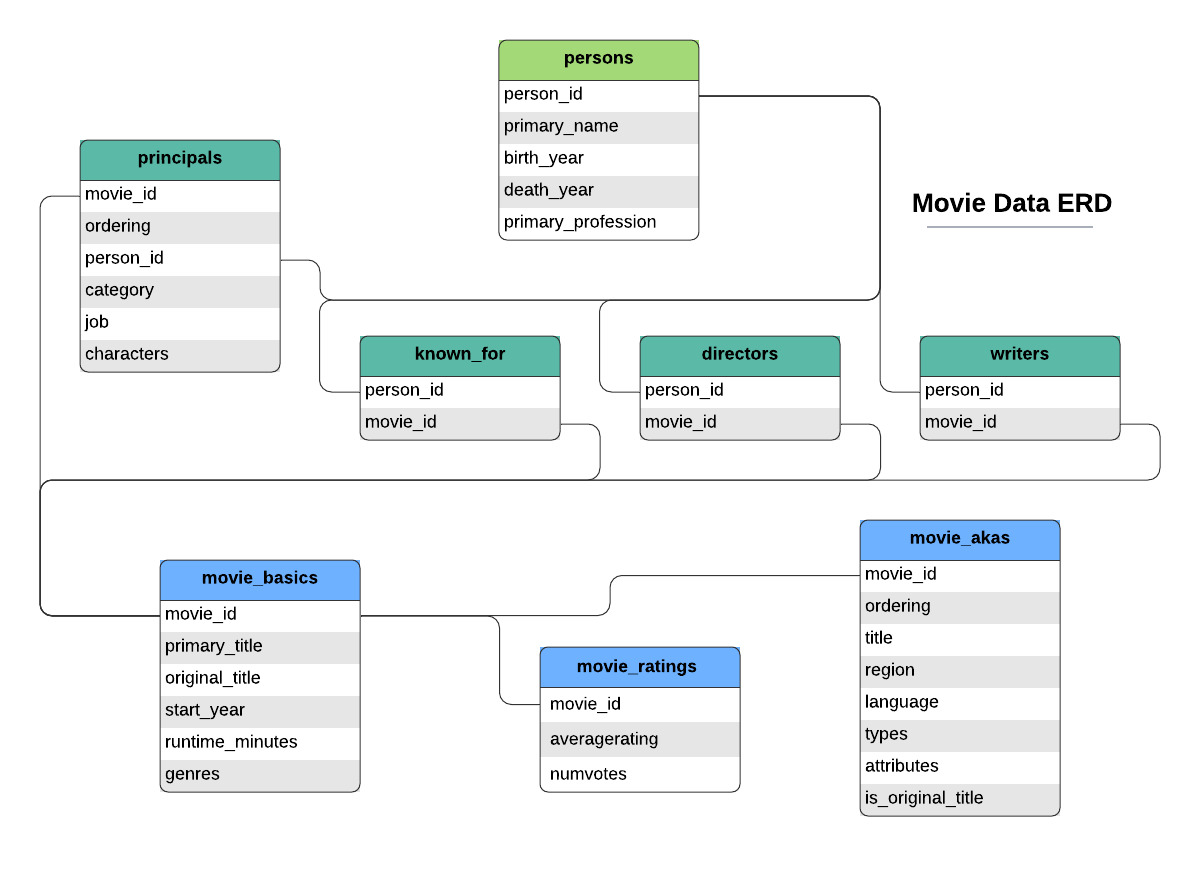

Here we're gonna be adding the necessary data from the database, since we'll be working with reviews...

This will get the writers into Q1

In [409]:
# WRITERS

q1 = pd.read_sql("""

SELECT
    
    r.primary_name,
    b.movie_id
    
FROM

    persons r
    JOIN writers b
        ON r.person_id = b.person_id
        
""", conn)

q1['writer'] = q1['primary_name']
q1 = q1.drop('primary_name', axis = 1)

This will get the directors into Q2

In [410]:
# DIRECTORS

q2 = pd.read_sql("""

SELECT
    
    r.primary_name,
    b.movie_id
    
FROM

    persons r
    JOIN directors b
        ON r.person_id = b.person_id
        
""", conn)

q2['director'] = q2['primary_name']
q2 = q2.drop('primary_name', axis = 1)

Now we will merge directors and writers into the same data set and then with main in Q1

In [411]:
q2 = pd.merge(q1, q2, left_on=['movie_id'], right_on = ['movie_id'])

In [412]:
q1 = pd.read_sql("""

SELECT
    
    r.averagerating,
    r.numvotes,
    r.movie_id,
    b.genres,
    b.original_title,
    b.primary_title,
    b.start_year
    
FROM

    movie_ratings r
    JOIN movie_basics b
        ON r.movie_id = b.movie_id
        
""", conn)

In [413]:
q1 = pd.merge(q1, q2, left_on=['movie_id'], right_on = ['movie_id'])

## Data Cleaning

In [414]:
# First we're gonna see how the data for Reviews is organized to determine types of data per column and unnecessary/problematic
# characters to get rid of

type(reviews)

pandas.core.frame.DataFrame

We're gonna count missing data per dataframe, we'll confirm missing data, count and add it all up

In [415]:
#IM.DB
q1.isna().sum()             #MISSING DATA IN GENRES

averagerating         0
numvotes              0
movie_id              0
genres            19556
original_title        0
primary_title         0
start_year            0
writer                0
director              0
dtype: int64

In [416]:
#REVIEWS
reviews.isna().sum()       #MISSING DATA IN REVIEW, RATING, CRITIC, TOP CRITIC AND PUBLISHER

id                0
review         5563
rating        13517
fresh             0
critic         2722
top_critic        0
publisher       309
date              0
dtype: int64

In [417]:
#MOVIEGROSS
movieGross.isna().sum()    #MISSING DATA IN DOMESTIC GROSS AND FOREIGN GROSS

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

In [418]:
#TMDBMOVIES
tmdbMovies.isna().sum()    #NO MISSING DATA

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [419]:
#MOVIEBUDGETS
movieBudgets.isna().sum()   #NO MISSING DATA

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [420]:
#INFO
movieInfo.isna().sum()     #MISSING DATA IN SYNOPSIS, RATING, GENRE, DIRECTOR, WRITER, THEATER DATE, DVD DATE, CURRENCY, BOX
                           #OFFICE, RUNTIME AND STUDIO

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

We create a copy of the dataframes which we will modify

In [421]:
reviews2 = reviews.copy()
q2 = q1.copy()
movieGross2 = movieGross.copy()
tmdbMovies2 = tmdbMovies.copy()
movieBudgets2 = movieBudgets.copy()
movieInfo2 = movieInfo.copy()

We fill empty reviews with unavailable chosen string by the team for consistency

In [422]:
reviews2[['review','rating','critic','publisher']] = reviews2[['review','rating','critic','publisher']].fillna('-')
q2['genres'] = q1['genres'].fillna('-')
movieGross2[['domestic_gross', 'foreign_gross']] = movieGross2[['domestic_gross', 'foreign_gross']].fillna('0')
movieGross2['studio'] = movieGross2['studio'].fillna('-')
movieInfo2[['synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']] = movieInfo2[['synopsis', 'rating', 'genre', 'director', 'writer', 'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime', 'studio']].fillna('-')

Here we confirm missing data has been filled out, count and add it all up missing data, should be 0

In [423]:
reviews2.isna().sum()

id            0
review        0
rating        0
fresh         0
critic        0
top_critic    0
publisher     0
date          0
dtype: int64

In [424]:
q2.isna().sum()

averagerating     0
numvotes          0
movie_id          0
genres            0
original_title    0
primary_title     0
start_year        0
writer            0
director          0
dtype: int64

In [425]:
movieGross2.isna().sum()

title             0
studio            0
domestic_gross    0
foreign_gross     0
year              0
dtype: int64

In [426]:
tmdbMovies2.isna().sum()

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [427]:
movieBudgets2.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [428]:
movieInfo2.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

## Data Preparation

### Reviews2

Here we set the date column to the appropriate format so we can further work on it

In [429]:
reviews2['date'] = pd.to_datetime(reviews2['date'])

Here we can see the new formatting for the date column

In [430]:
reviews2['date'].dtypes

dtype('<M8[ns]')

Here we add new columns for year, days and months

In [431]:
# Month
reviews2['Month'] = reviews2['date'].dt.month
# Day
reviews2['Day'] = reviews2['date'].dt.day
# Year
reviews2['Year'] = reviews2['date'].dt.year

Here we can see which are the values of dates from newest to oldest, Most recent = 2018 and oldest 1800?

In [432]:
reviews2['date'].sort_values(ascending = False)

29476   2018-12-06
45239   2018-12-06
32362   2018-12-06
30438   2018-12-06
29473   2018-12-06
           ...    
4136    1951-10-15
16148   1800-01-01
50023   1800-01-01
13856   1800-01-01
16497   1800-01-01
Name: date, Length: 54432, dtype: datetime64[ns]

Here we check what's one of those 1800s date and we can see its a mistake, therefore we'll be removing these inaccurate logs

In [433]:
display(reviews2.iloc[16497])

id                                                          669
review        Terry Gilliam's third fantasy feature may not ...
rating                                                        -
fresh                                                     fresh
critic                                       Jonathan Rosenbaum
top_critic                                                    1
publisher                                        Chicago Reader
date                                        1800-01-01 00:00:00
Month                                                         1
Day                                                           1
Year                                                       1800
Name: 16497, dtype: object

Here we filter out all data prior to 1900 and confirm the data has been indeed filtered out

In [434]:
reviews2 = reviews2[(reviews2['date'].dt.year > 1900)]

reviews2['Year'].sort_values(ascending = False)

0        2018
33984    2018
33986    2018
33987    2018
33988    2018
         ... 
43963    1965
20142    1958
9665     1953
4137     1951
4136     1951
Name: Year, Length: 54428, dtype: int64

### IM.DB (Q2)

In [435]:
q2['start_year'].sort_values(ascending = False)

0         2019
835537    2019
835507    2019
835506    2019
835505    2019
          ... 
377427    2010
377426    2010
377425    2010
377424    2010
468823    2010
Name: start_year, Length: 46166004, dtype: int64

### MOVIE GROSS 2

Removing commas from numeric columns

In [436]:
#movieGross2['domestic_gross'] = movieGross2['domestic_gross'].str.replace(',','')
movieGross2['foreign_gross'] = movieGross2['foreign_gross'].str.replace(',','')

Setting the right formatting for the numeric columns

In [437]:
movieGross2['domestic_gross'] = movieGross2['domestic_gross'].astype(float)
movieGross2['foreign_gross'] = movieGross2['foreign_gross'].astype(float)

### tmdbMovies 2

Setting the right formatting for the dataframe's columns

In [438]:
tmdbMovies2['popularity'] = tmdbMovies2['popularity'].astype(float)
tmdbMovies2['vote_average'] = tmdbMovies2['vote_average'].astype(float)
tmdbMovies2['vote_count'] = tmdbMovies2['vote_count'].astype(float)
tmdbMovies2['id'] = tmdbMovies2['id'].astype(int)
tmdbMovies2['release_date'] = pd.to_datetime(tmdbMovies2['release_date'])

### movieBudgets 2

Removing commas and special characters from numeric columns

In [439]:
movieBudgets2['domestic_gross'] = movieBudgets2['domestic_gross'].str.replace(',','')
movieBudgets2['domestic_gross'] = movieBudgets2['domestic_gross'].replace({'\$':''}, regex = True)
movieBudgets2['worldwide_gross'] = movieBudgets2['worldwide_gross'].str.replace(',','')
movieBudgets2['worldwide_gross'] = movieBudgets2['worldwide_gross'].replace({'\$':''}, regex = True)
movieBudgets2['production_budget'] = movieBudgets2['production_budget'].str.replace(',','')
movieBudgets2['production_budget'] = movieBudgets2['production_budget'].replace({'\$':''}, regex = True)

Setting the right formatting for the numeric and date columns

In [440]:
movieBudgets2['domestic_gross'] = movieBudgets2['domestic_gross'].astype(float)
movieBudgets2['worldwide_gross'] = movieBudgets2['worldwide_gross'].astype(float)
movieBudgets2['production_budget'] = movieBudgets2['production_budget'].astype(float)
movieBudgets2['release_date'] = pd.to_datetime(movieBudgets2['release_date'])

### movieInfo 2

Setting the right formatting for the dataframe's date columns

In [441]:
# Removing the minutes word from the data
movieInfo2['runtime'] = movieInfo2['runtime'].replace({'minutes':''}, regex = True)    #THIS COLUMN IS IN MINUTES! REMINDER!!!

# ADJUSTING THE DATES TO ACCEPTABLE FORMAT

# THEATER_DATE
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Jan':'01 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Feb':'02 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Mar':'03 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Apr':'04 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'May':'05 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Jun':'06 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Jul':'07 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Aug':'08 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Sep':'09 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Oct':'10 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Nov':'11 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({'Dec':'12 -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({',':' -'}, regex = True)
movieInfo2['theater_date'] = movieInfo2['theater_date'].replace({' ':''}, regex = True)
movieInfo2 = movieInfo2[(movieInfo2['theater_date'] != '-')]
movieInfo2['theater_date'] = pd.to_datetime(movieInfo2['theater_date'])

# DVD_DATE
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Jan':'01 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Feb':'02 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Mar':'03 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Apr':'04 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'May':'05 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Jun':'06 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Jul':'07 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Aug':'08 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Sep':'09 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Oct':'10 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Nov':'11 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({'Dec':'12 -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({',':' -'}, regex = True)
movieInfo2['dvd_date'] = movieInfo2['dvd_date'].replace({' ':''}, regex = True)
movieInfo2 = movieInfo2[(movieInfo2['dvd_date'] != '-')]
movieInfo2['dvd_date'] = pd.to_datetime(movieInfo2['dvd_date'])

# BOX OFFICE
movieInfo2 = movieInfo2[(movieInfo2['box_office'] != '-')]
movieInfo2['box_office'] = movieInfo2['box_office'].str.replace(',','')
movieInfo2['box_office'] = movieInfo2['box_office'].astype(float)

# RUNTIME
movieInfo2 = movieInfo2[(movieInfo2['runtime'] != '-')]
movieInfo2['runtime'] = movieInfo2['runtime'].astype(int)

### tmdbMovies2

Removing unnecessary column and order columns

In [442]:
tmdbMovies2 = tmdbMovies2.drop('Unnamed: 0', axis = 1)
new_cols = ["id", "genre_ids", "title", "original_title", "popularity", "release_date", "vote_average", "vote_count", "original_language"]
tmdbMovies2 = tmdbMovies2.reindex(columns=new_cols)

## Data Exploration

### Here we're gonna work on combining dataframes to get precise results

We'll be merging all datasets to get one for our visualizations

In [443]:
movdf1 = pd.merge(movieGross2, tmdbMovies2, left_on = ['title'], right_on = ['title'])
movdf1 = pd.merge(movieBudgets2, movdf1, left_on = ['movie','release_date'], right_on = ['title','release_date'])
movdf1 = pd.merge(q2, movdf1, left_on=['original_title','primary_title'], right_on = ['original_title','title'])

movdf2 = pd.merge(reviews2, movieInfo2, left_on=['id'], right_on = ['id'])
movdf2 = pd.merge(movdf2, movdf1, left_on=['director','writer'], right_on = ['director','writer'])

### Quick clean of new tables

Now we're gonna remove duplicates from this final dataset

In [444]:
movdf2['review'] = movdf2['review'].str.replace('-','False')
movdf2 = movdf2.drop_duplicates(subset = 'review', keep = False)

We switched our - to false so we could keep them during our cleaning

In [445]:
movdf2['review'] = movdf2['review'].str.replace('False','-')

Let's create a copy remove useless columns for our purpose

In [446]:
movdf3 = movdf2.copy()

We'll calculate total gross to use on ROI

In [447]:
movdf3['total_gross'] = movdf3['domestic_gross_y'] + movdf3['foreign_gross']

We'll calculate ROI

In [448]:
movdf3['ROI'] = (movdf3['total_gross'] / movdf3['production_budget'])*100

Now let's remove useless columns for our purpose

In [449]:
#movdf2 = movdf2.drop('synopsis', axis = 1)
movdf3 = movdf3.drop('id_y', axis = 1)
movdf3 = movdf3.drop('genre_ids', axis = 1)
movdf3 = movdf3.drop('top_critic', axis = 1)
movdf3 = movdf3.drop('Year', axis = 1)
movdf3 = movdf3.drop('year', axis = 1)
movdf3 = movdf3.drop('Month', axis = 1)
movdf3 = movdf3.drop('Day', axis = 1)
movdf3 = movdf3.drop('domestic_gross_x', axis = 1)
movdf3 = movdf3.drop('domestic_gross_y', axis = 1)
movdf3 = movdf3.drop('foreign_gross', axis = 1)
movdf3 = movdf3.drop('original_language', axis = 1)
movdf3 = movdf3.drop('production_budget', axis = 1)
movdf3 = movdf3.drop('title', axis = 1)
movdf3 = movdf3.drop('synopsis', axis = 1)
movdf3 = movdf3.drop('review', axis = 1)
movdf3 = movdf3.drop('rating_x', axis = 1)
movdf3 = movdf3.drop('rating_y', axis = 1)
movdf3 = movdf3.drop('id_x', axis = 1)
movdf3 = movdf3.drop('worldwide_gross', axis = 1)
movdf3 = movdf3.drop('theater_date', axis = 1)
movdf3 = movdf3.drop('dvd_date', axis = 1)
movdf3 = movdf3.drop('start_year', axis = 1)
movdf3 = movdf3.drop('release_date', axis = 1)
movdf3 = movdf3.drop('date', axis = 1)
movdf3 = movdf3.drop('total_gross', axis = 1)
movdf3 = movdf3.drop('writer', axis = 1)
movdf3 = movdf3.drop('currency', axis = 1)
movdf3 = movdf3.drop('original_title', axis = 1)
movdf3 = movdf3.drop('primary_title', axis = 1)
movdf3 = movdf3.drop('movie_id', axis = 1)
movdf3 = movdf3.drop('studio_y', axis = 1)
movdf3 = movdf3.drop('genre', axis = 1)
movdf3 = movdf3.drop('popularity', axis = 1)

Renaming our columns to make it easier to process

In [450]:
movdf3['numvotes1'] = movdf3['numvotes']
movdf3 = movdf3.drop('numvotes', axis = 1)
movdf3['avgrating1'] = movdf3['averagerating']
movdf3 = movdf3.drop('averagerating', axis = 1)
movdf3['avgrating2'] = movdf3['vote_average']
movdf3 = movdf3.drop('vote_average', axis = 1)
movdf3['numvotes2'] = movdf3['vote_count']
movdf3 = movdf3.drop('vote_count', axis = 1)
movdf3['studio'] = movdf3['studio_x']
movdf3 = movdf3.drop('studio_x', axis = 1)

Organizing columns in an order that's best suited for our analysis

In [453]:
new_cols = ["id","movie","genres","runtime","director","studio","critic","fresh","publisher","numvotes1","avgrating1","numvotes2","avgrating2","ROI","box_office"]
movdf3 = movdf3[new_cols]

In [454]:
movdf3

,id,movie,genres,runtime,director,studio,critic,fresh,publisher,numvotes1,avgrating1,numvotes2,avgrating2,ROI,box_office
3162,211,Melancholia,"Drama,Sci-Fi",137,Lars von Trier,Fine Line Features,David Ansen,fresh,Newsweek,153434,7.2,1642.0,7.1,169.148936,2839256.0
3163,211,Melancholia,"Drama,Sci-Fi",137,Lars von Trier,Fine Line Features,Emanuel Levy,fresh,EmanuelLevy.Com,153434,7.2,1642.0,7.1,169.148936,2839256.0
3164,211,Melancholia,"Drama,Sci-Fi",137,Lars von Trier,Fine Line Features,Cole Smithey,fresh,ColeSmithey.com,153434,7.2,1642.0,7.1,169.148936,2839256.0
3165,211,Melancholia,"Drama,Sci-Fi",137,Lars von Trier,Fine Line Features,Tim Brayton,rotten,Antagony &amp; Ecstasy,153434,7.2,1642.0,7.1,169.148936,2839256.0
3166,211,Melancholia,"Drama,Sci-Fi",137,Lars von Trier,Fine Line Features,Rob Gonsalves,fresh,eFilmCritic.com,153434,7.2,1642.0,7.1,169.148936,2839256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10191,1646,Nebraska,"Adventure,Comedy,Drama",115,Alexander Payne,Paramount Pictures,Guy Lodge,rotten,HitFix,105304,7.7,967.0,7.4,230.833333,11348612.0
10192,1646,Nebraska,"Adventure,Comedy,Drama",115,Alexander Payne,Paramount Pictures,Robbie Collin,fresh,Daily Telegraph (UK),105304,7.7,967.0,7.4,230.833333,11348612.0
10193,1646,Nebraska,"Adventure,Comedy,Drama",115,Alexander Payne,Paramount Pictures,Peter Bradshaw,fresh,Guardian,105304,7.7,967.0,7.4,230.833333,11348612.0
10194,1646,Nebraska,"Adventure,Comedy,Drama",115,Alexander Payne,Paramount Pictures,Keith Uhlich,rotten,Time Out,105304,7.7,967.0,7.4,230.833333,11348612.0


## Data Visualization

### Preparing the data

Firstly we're gonna create a set of the top movies with the best box office results

#### Setting up preliminary charts with the first dataframe

<AxesSubplot:title={'center':'Most Popular Movies'}, ylabel='title'>

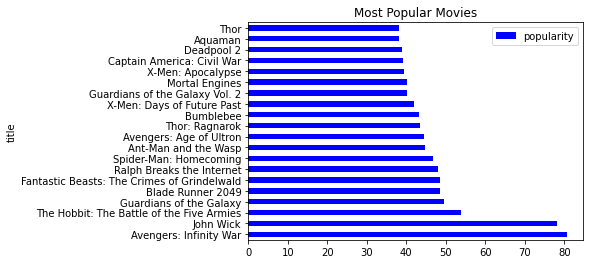

In [1077]:
#Graphing most popular movies
mp_t1.plot.barh(x='title', y='popularity', title='Most Popular Movies', color='blue')

<AxesSubplot:title={'center':'Highest Grossing Movies'}, ylabel='title'>

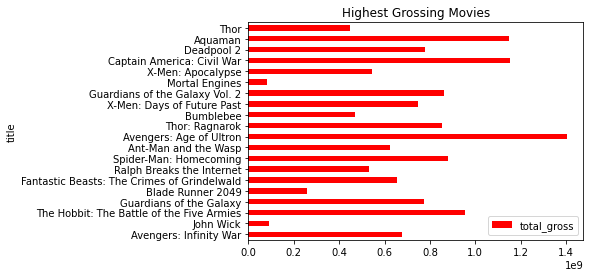

In [1078]:
#Graphing highest grossing movies
mp_t1.plot.barh(x='title', y='total_gross', title='Highest Grossing Movies', color='red')

#### Setting up preliminary charts with the second dataframe

In [1130]:
# Creating a list of FRESH-ROTTEN / BOX OFFICE
mp_t2 = movdf2_3[['fresh_y','box_office','movie', 'production_budget','worldwide_gross']].copy()
mp_t2 = mp_t2.drop_duplicates(subset = 'movie')
mp_t2 = mp_t2.sort_values(by='worldwide_gross', ascending=False)[:10]

In [1176]:
#Graphing most popular movies
#mp_t2.groupby(['movie','fresh_y']).movie.count().unstack().plot(kind='barh', legend=False, color=['r', 'b'])
#mp_t2.groupby(['movie','fresh_y']).movie.count().unstack().plot.barh(x='movie', y='worldwide_gross', title='Highest Grossing Movies', color=['r','b'])
#mp_t2.plot.barh(x='movie', y='worldwide_gross', title='Critics Reviews', color='red')

#mp_t2.groupby(['movie', 'fresh_y']).count().plot(kind='barh', legend=False, color=['r', 'g'])

In [1177]:
# Grouping by
#group_mt2 = mp_t2.groupby(['movie', 'fresh_y']).count()
# Creating pivot table
#table = pd.pivot_table(group_mt2, index = 'movie', columns='fresh_y', values='worldwide_gross')
# Setting coloring
#table.plot(kind='barh', color=['g', 'r'])
#import seaborn as sns

#sns.barplot(data = table, x = 'worldwide_gross', y = 'fresh_y', hue = 'fresh_y', title='Critics Reviews', color='red')
# bar plot vertical?
#mp_t2.plot.barh(x = 'fresh_y', y = 'worldwide_gross', title='Critics Reviews', color='red')
#Graphing most popular movies
#mp_t2.plot.barh(x='movie', y='worldwide_gross', title='Highest Grossing Movies', color='blue')